# Project Notebook - Group 4

# Part 1: Data importing & preprocessing

In [203]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [204]:
# Read in file
house_df = pd.read_csv("Data/house_sales.csv")
house_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [205]:
house_df.isnull().sum()

id                  0
date                0
price               0
bedrooms         1134
bathrooms        1068
sqft_living      1110
sqft_lot         1044
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Missing values for sqft_living

In [207]:
# Fill missing values for sqft_living
house_df['sqft_living'] = house_df['sqft_living'].fillna(house_df['sqft_above'] + house_df['sqft_basement'])

# Check for missing values
print(f"sqft_living missing values: {house_df['sqft_living'].isnull().sum()}")

sqft_living missing values: 0


### Missing values for bedrooms and bathrooms

In [209]:
# Use sqft_living bins to fill missing values for bedroom and bathroom
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, float('inf')]
labels = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '6000+']
house_df['sqft_bin'] = pd.cut(house_df['sqft_living'], bins=bins, labels=labels)

In [210]:
# Drop rows with missing values in the relevant columns just for the calculation
grouped_avgs = house_df.dropna(subset=['bedrooms', 'bathrooms']).groupby('sqft_bin')[['bedrooms', 'bathrooms']].mean().round()
print(grouped_avgs)

           bedrooms  bathrooms
sqft_bin                      
0-1000          2.0        1.0
1000-2000       3.0        2.0
2000-3000       4.0        2.0
3000-4000       4.0        3.0
4000-5000       4.0        3.0
5000-6000       5.0        4.0
6000+           5.0        5.0


In [211]:
# Create dictionaries from the grouped_avgs to map bins to fill missing values with
bed_avg = grouped_avgs['bedrooms'].to_dict()
bath_avg = grouped_avgs['bathrooms'].to_dict()

# Fill missing values for bedrooms
house_df.loc[house_df['bedrooms'].isna(), 'bedrooms'] = (
    house_df.loc[house_df['bedrooms'].isna(), 'sqft_bin'].map(bed_avg))

# Fill missing values for bathrooms
house_df.loc[house_df['bathrooms'].isna(), 'bathrooms'] = (
    house_df.loc[house_df['bathrooms'].isna(), 'sqft_bin'].map(bath_avg))

In [212]:
# Check for missing values
print(f"bedrooms missing values: {house_df['bedrooms'].isnull().sum()}")
print(f"bathrooms missing values: {house_df['bathrooms'].isnull().sum()}")

bedrooms missing values: 0
bathrooms missing values: 0


### Checking bedroom outliers

In [214]:
# Checking bedrooms for outliers
print(f"bedroom values: {sorted(house_df['bedrooms'].unique())}")

bedroom values: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 33.0]


<Axes: ylabel='bedrooms'>

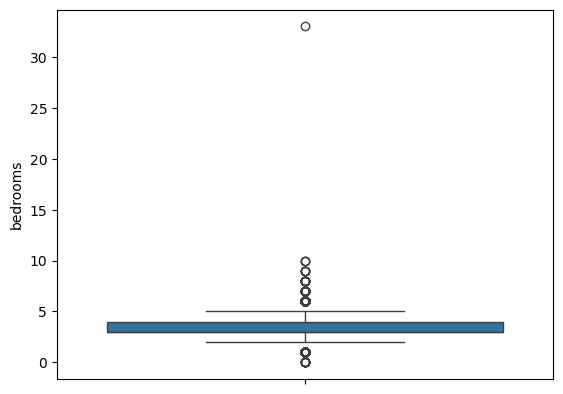

In [215]:
# Bedrooms boxplot
sns.boxplot(house_df['bedrooms'])

In [216]:
# Count of how many homes have an outlier value of bedrooms
print(f"Over 10 bedrooms: {(house_df['bedrooms'] > 10).sum()}")
print(f"10 bedrooms: {(house_df['bedrooms'] == 10).sum()}")
print(f"9 bedrooms: {(house_df['bedrooms'] == 9).sum()}")
print(f"8 bedrooms: {(house_df['bedrooms'] == 8).sum()}")
print(f"7 bedrooms: {(house_df['bedrooms'] == 7).sum()}")
print(f"6 bedrooms: {(house_df['bedrooms'] == 6).sum()}")
print(f"1 bedrooms: {(house_df['bedrooms'] == 1).sum()}")
print(f"0 bedrooms: {(house_df['bedrooms'] == 0).sum()}")

Over 10 bedrooms: 1
10 bedrooms: 3
9 bedrooms: 5
8 bedrooms: 12
7 bedrooms: 34
6 bedrooms: 263
1 bedrooms: 189
0 bedrooms: 11


In [217]:
# Drop outlier values of bedrooms (0, 7, 8, 9, 10, 33)
bedroom_clean = house_df.drop(house_df[house_df['bedrooms'].isin([0, 7, 8, 9, 10, 33])].index)
sorted(bedroom_clean['bedrooms'].unique())

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

### Checking bathroom outliers

In [219]:
# Checking bathrooms for outliers
print(f"bathroom values: {sorted(bedroom_clean['bathrooms'].unique())}")

bathroom values: [0.0, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.75, 8.0]


In [220]:
# Adjusting bathroom values to be whole or half (no 0.25 or 0.75 values)
def clean_bathroom_value(x):
    # 0.25 values will be rounded down to nearest whole value
    decimal = x % 1
    if decimal == 0.25: 
        return np.floor(x) # floor rounds down
    # 0.75 values will be rounded up to nearest whole value
    elif decimal == 0.75:
        return np.ceil(x) # ceil rounds up
    else:
        return x

# Apply function
bedroom_clean['bathrooms'] = bedroom_clean['bathrooms'].apply(clean_bathroom_value)

# Check if function worked
print(f"bathroom values: {sorted(bedroom_clean['bathrooms'].unique())}")

bathroom values: [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 8.0]


<Axes: ylabel='bathrooms'>

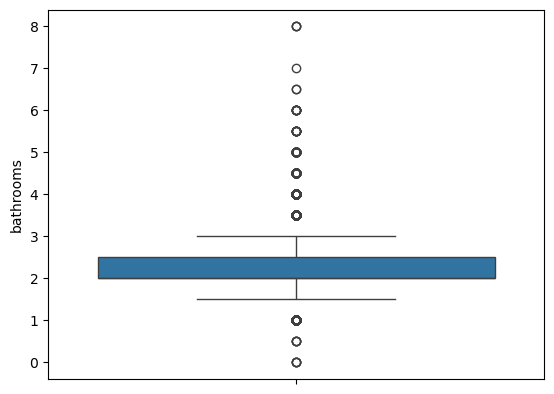

In [221]:
# Bathrooms boxplot
sns.boxplot(bedroom_clean['bathrooms'])

In [222]:
# Count of how many homes have an outlier value of bathrooms
print(f"More than 6 bathrooms: {(bedroom_clean['bathrooms'] > 6).sum()}")
print(f"Less than 1 bathroom: {(bedroom_clean['bathrooms'] < 1).sum()}")

More than 6 bathrooms: 6
Less than 1 bathroom: 8


In [223]:
# Drop outlier values for bathrooms
bathroom_clean = bedroom_clean[(bedroom_clean['bathrooms'] >= 1) & (bedroom_clean['bathrooms'] <= 6)]
sorted(bathroom_clean['bathrooms'].unique())

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

### Missing values for sqft_lot

In [225]:
# Replace missing 'sqft_lot' values with the averaged 'sqft_lot15' values
bathroom_clean['sqft_lot'] = bathroom_clean['sqft_lot'].fillna(bathroom_clean['sqft_lot15'])

print(f"sqft_lot missing values: {bathroom_clean['sqft_lot'].isnull().sum()}")

sqft_lot missing values: 0


In [226]:
bathroom_clean.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
sqft_bin         0
dtype: int64

### New dataframe with adjusted values 

In [228]:
# Create new clean house dataframe with changes made
house_clean = bathroom_clean[['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                              'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement',
                              'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long']]

In [229]:
house_clean

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,20141013T000000,221900.0,3.0,1.0,1180.0,5650.0,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257
1,6414100192,20141209T000000,538000.0,3.0,2.0,2570.0,7242.0,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319
2,5631500400,20150225T000000,180000.0,2.0,1.0,770.0,10000.0,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233
3,2487200875,20141209T000000,604000.0,4.0,3.0,1960.0,5000.0,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393
4,1954400510,20150218T000000,510000.0,3.0,2.0,1680.0,8080.0,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3.0,2.5,1530.0,1131.0,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346
21609,6600060120,20150223T000000,400000.0,4.0,2.5,2310.0,5813.0,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362
21610,1523300141,20140623T000000,402101.0,2.0,1.0,1020.0,1350.0,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299
21611,291310100,20150116T000000,400000.0,3.0,2.5,1600.0,2388.0,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069


In [230]:
house_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21533 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21533 non-null  int64  
 1   date           21533 non-null  object 
 2   price          21533 non-null  float64
 3   bedrooms       21533 non-null  float64
 4   bathrooms      21533 non-null  float64
 5   sqft_living    21533 non-null  float64
 6   sqft_lot       21533 non-null  float64
 7   floors         21533 non-null  float64
 8   waterfront     21533 non-null  int64  
 9   view           21533 non-null  int64  
 10  condition      21533 non-null  int64  
 11  grade          21533 non-null  int64  
 12  sqft_above     21533 non-null  int64  
 13  sqft_basement  21533 non-null  int64  
 14  yr_built       21533 non-null  int64  
 15  yr_renovated   21533 non-null  int64  
 16  zipcode        21533 non-null  int64  
 17  lat            21533 non-null  float64
 18  long       

In [231]:
# Convert date into datetime dtype
house_clean['date'] = pd.to_datetime(house_clean['date'], format='%Y%m%dT%H%M%S')

# Remove the hours, minutes, and second -- keep only year, month, day
house_clean['date'] = house_clean['date'].dt.date

In [232]:
# Convert bedrooms, sqft_living, and sqft_lot into int
house_clean['bedrooms'] = house_clean['bedrooms'].astype('int64')
house_clean['sqft_living'] = house_clean['sqft_living'].astype('int64')
house_clean['sqft_lot'] = house_clean['sqft_lot'].astype('int64')

In [233]:
# Run correlations
house_w_basements = house_clean[(house_clean['sqft_basement'] > 0)] # Remove houses without basement
house_corr = house_w_basements[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement']]
house_corr.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
price,1.000000,0.258068,0.500294,0.703862,0.062602,0.343925,0.313183,0.450005,0.072745,0.693451,0.704981,0.395954
bedrooms,0.258068,1.000000,0.448244,0.520277,0.063404,0.059936,-0.000412,0.106389,0.073541,0.269651,0.422708,0.464609
bathrooms,0.500294,0.448244,1.000000,0.679438,0.119290,0.422107,0.087785,0.237085,-0.040035,0.598484,0.663081,0.412684
sqft_living,0.703862,0.520277,0.679438,1.000000,0.210646,0.321004,0.146422,0.369012,0.026657,0.729540,0.915811,0.712430
sqft_lot,0.062602,0.063404,0.119290,0.210646,1.000000,-0.016505,0.047530,0.053413,0.001947,0.118356,0.193708,0.148680
floors,0.343925,0.059936,0.422107,0.321004,-0.016505,1.000000,0.050323,0.128657,-0.166172,0.457988,0.496285,-0.124802
waterfront,0.313183,-0.000412,0.087785,0.146422,0.047530,0.050323,1.000000,0.368822,0.012151,0.129771,0.133598,0.105184
view,0.450005,0.106389,0.237085,0.369012,0.053413,0.128657,0.368822,1.000000,0.029917,0.378134,0.332009,0.273268
condition,0.072745,0.073541,-0.040035,0.026657,0.001947,-0.166172,0.012151,0.029917,1.000000,-0.093578,-0.061490,0.169093
grade,0.693451,0.269651,0.598484,0.729540,0.118356,0.457988,0.129771,0.378134,-0.093578,1.000000,0.758288,0.362194


In [234]:
house_clean

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,2014-10-13,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257
1,6414100192,2014-12-09,538000.0,3,2.0,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319
2,5631500400,2015-02-25,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233
3,2487200875,2014-12-09,604000.0,4,3.0,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393
4,1954400510,2015-02-18,510000.0,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.5,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346
21609,6600060120,2015-02-23,400000.0,4,2.5,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362
21610,1523300141,2014-06-23,402101.0,2,1.0,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299
21611,291310100,2015-01-16,400000.0,3,2.5,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069


In [235]:
# house_clean.to_csv('Data/house_updated.csv', index=False)
house_updated_df = pd.read_csv("Data/house_updated.csv")

# Part 2: Data Analysis and Visualization

In [237]:
house_updated_df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
dtype: object

Numerical Variables: id, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, sqft_above, sqft_basement, yr_built,
yr_renovated, zipcode, lat, long (sqft_living15, sqft_lot15 removed from new updated csv file ?? )
(Continous: price, sqft_living, floors, sqft_above, sqft_basement, lat, long)
(Discrete: id, bedrooms, yr_built, yr_renovated, zipcode)
Categorical variables: waterfront , view, condition, zipcode 
Ordinal Variables: grade
Date Variable: Date

In [380]:
# New dataframe to show variable dtypes
house_data = {
    'Column': ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
    'Type': ['Numerical - Discrete', 'Date', 'Numerical - Continuous', 'Numerical - Discrete', 'Numerical - Continuous', 'Numerical - Continuous', 'Numerical - Continuous', 'Numerical - Continuous', 'Categorical - Binary', 'Categorical - Binary', 'Categorical - Ordinal',
             'Ordinal - Ranked', 'Numerical - Continuous', 'Numerical - Continuous', 'Numerical - Discrete', 'Numerical -Discrete', 'Numerical/Categorical', 'Numerical - Continuous', 'Numerical - Continuous', 'Numerical - Continuous', 'Numerical - Continuous'],
}
house_data_variables_type_df = pd.DataFrame(house_data)
house_data_variables_type_df

,Column,Type
0,id,Numerical - Discrete
1,date,Date
2,price,Numerical - Continuous
3,bedrooms,Numerical - Discrete
4,bathrooms,Numerical - Continuous
5,sqft_living,Numerical - Continuous
6,sqft_lot,Numerical - Continuous
7,floors,Numerical - Continuous
8,waterfront,Categorical - Binary
9,view,Categorical - Binary


In [356]:
# Describe measures of centrality
house_MC_df = house_updated_df.describe()
house_MC_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
count,2.153300e+04,2.153300e+04,21533.000000,21533.000000,21533.000000,2.153300e+04,21533.000000,21533.000000,21533.000000,21533.000000,21533.000000,21533.000000,21533.000000,21533.000000,21533.000000,21533.000000,21533.000000,21533.000000
mean,4.581234e+09,5.381202e+05,3.363814,2.127943,2074.000882,1.498036e+04,1.493289,0.007523,0.233456,3.409697,7.655273,1784.214276,289.786607,1971.032369,84.065156,98077.932104,47.559950,-122.213878
std,2.876951e+09,3.577792e+05,0.865352,0.740928,903.190071,4.074740e+04,0.539486,0.086412,0.764829,0.650442,1.169622,819.374662,438.644030,29.357111,400.907056,53.522649,0.138645,0.140809
min,1.000102e+06,7.800000e+04,1.000000,1.000000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000
25%,2.123049e+09,3.215000e+05,3.000000,2.000000,1420.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.470400,-122.328000
50%,3.904931e+09,4.500000e+05,3.000000,2.000000,1910.000000,7.614000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571600,-122.230000
75%,7.312100e+09,6.428600e+05,4.000000,2.500000,2540.000000,1.061500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678100,-122.125000
max,9.900000e+09,7.062500e+06,6.000000,6.000000,10040.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8020.000000,3500.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000


In [358]:
# New dataframes to include: range, variance, mode, and IQR for each variable excluding ID, Date, zipcode, lat, long

In [242]:
price_mean = round(house_updated_df['price'].mean(), 3)
price_mode = house_updated_df['price'].mode().iloc[0]
price_median = house_updated_df['price'].median()
price_std = round(house_updated_df['price'].std(), 3)
price_variance = round(house_updated_df['price'].var(), 3)
price_max = house_updated_df['price'].max()
price_min = house_updated_df['price'].min()
price_range = price_max - price_min
price_q1 = house_updated_df['price'].quantile(0.25)
price_q3 = house_updated_df['price'].quantile(0.75)
price_iqr = price_q3 - price_q1

price_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [price_mean, price_mode, price_median, price_std, price_variance, price_max, price_min, price_range, price_q1, price_q3, price_iqr]
    })
print("Price")
price_measures_centrality_df

Price


,Measure,Value
0,Mean,5.381202e+05
1,Mode,3.500000e+05
2,Median,4.500000e+05
3,Standard Deviation,3.577792e+05
4,Variance,1.280060e+11
5,Max,7.062500e+06
6,Min,7.800000e+04
7,Range,6.984500e+06
8,25% Quartile,3.215000e+05
9,75% Quartile,6.428600e+05


In [243]:
bedrooms_mean = round(house_updated_df['bedrooms'].mean(), 3)
bedrooms_mode = house_updated_df['bedrooms'].mode().iloc[0]
bedrooms_median = house_updated_df['bedrooms'].median()
bedrooms_std = round(house_updated_df['bedrooms'].std(), 3)
bedrooms_variance = round(house_updated_df['bedrooms'].var(), 3)
bedrooms_max = house_updated_df['bedrooms'].max()
bedrooms_min = house_updated_df['bedrooms'].min()
bedrooms_range = bedrooms_max - bedrooms_min
bedrooms_q1 = house_updated_df['bedrooms'].quantile(0.25)
bedrooms_q3 = house_updated_df['bedrooms'].quantile(0.75)
bedrooms_iqr = bedrooms_q3 - bedrooms_q1

bedrooms_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [bedrooms_mean, bedrooms_mode, bedrooms_median, bedrooms_std, bedrooms_variance, bedrooms_max, bedrooms_min, bedrooms_range, bedrooms_q1, bedrooms_q3, bedrooms_iqr]
    })
print("Bedrooms")
bedrooms_measures_centrality_df

Bedrooms


,Measure,Value
0,Mean,3.364
1,Mode,3.000
2,Median,3.000
3,Standard Deviation,0.865
4,Variance,0.749
5,Max,6.000
6,Min,1.000
7,Range,5.000
8,25% Quartile,3.000
9,75% Quartile,4.000


In [244]:
bathrooms_mean = round(house_updated_df['bathrooms'].mean(), 3)
bathrooms_mode = house_updated_df['bathrooms'].mode().iloc[0]
bathrooms_median = house_updated_df['bathrooms'].median()
bathrooms_std = round(house_updated_df['bathrooms'].std(), 3)
bathrooms_variance = round(house_updated_df['bathrooms'].var(), 3)
bathrooms_max = house_updated_df['bathrooms'].max()
bathrooms_min = house_updated_df['bathrooms'].min()
bathrooms_range = bathrooms_max - bathrooms_min
bathrooms_q1 = house_updated_df['bathrooms'].quantile(0.25)
bathrooms_q3 = house_updated_df['bathrooms'].quantile(0.75)
bathrooms_iqr = bathrooms_q3 - bathrooms_q1

bathrooms_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [bathrooms_mean, bathrooms_mode, bathrooms_median, bathrooms_std, bathrooms_variance, bathrooms_max, bathrooms_min, bathrooms_range, bathrooms_q1, bathrooms_q3, bathrooms_iqr]
    })
print("Bathrooms")
bathrooms_measures_centrality_df

Bathrooms


,Measure,Value
0,Mean,2.128
1,Mode,2.000
2,Median,2.000
3,Standard Deviation,0.741
4,Variance,0.549
5,Max,6.000
6,Min,1.000
7,Range,5.000
8,25% Quartile,2.000
9,75% Quartile,2.500


In [245]:
sqft_living_mean = round(house_updated_df['sqft_living'].mean(), 3)
sqft_living_mode = house_updated_df['sqft_living'].mode().iloc[0]
sqft_living_median = house_updated_df['sqft_living'].median()
sqft_living_std = round(house_updated_df['sqft_living'].std(), 3)
sqft_living_variance = round(house_updated_df['sqft_living'].var(), 3)
sqft_living_max = house_updated_df['sqft_living'].max()
sqft_living_min = house_updated_df['sqft_living'].min()
sqft_living_range = sqft_living_max - sqft_living_min
sqft_living_q1 = house_updated_df['sqft_living'].quantile(0.25)
sqft_living_q3 = house_updated_df['sqft_living'].quantile(0.75)
sqft_living_iqr = sqft_living_q3 - sqft_living_q1

sqft_living_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [sqft_living_mean, sqft_living_mode, sqft_living_median, sqft_living_std, sqft_living_variance, sqft_living_max, sqft_living_min, sqft_living_range, sqft_living_q1, sqft_living_q3, sqft_living_iqr]
    })
print("Sqft_Living")
sqft_living_measures_centrality_df

Sqft_Living


,Measure,Value
0,Mean,2074.001
1,Mode,1300.000
2,Median,1910.000
3,Standard Deviation,903.190
4,Variance,815752.304
5,Max,10040.000
6,Min,370.000
7,Range,9670.000
8,25% Quartile,1420.000
9,75% Quartile,2540.000


In [246]:
sqft_lot_mean = round(house_updated_df['sqft_lot'].mean(), 3)
sqft_lot_mode = house_updated_df['sqft_lot'].mode().iloc[0]
sqft_lot_median = house_updated_df['sqft_lot'].median()
sqft_lot_std = round(house_updated_df['sqft_lot'].std(), 3)
sqft_lot_variance = round(house_updated_df['sqft_lot'].var(), 3)
sqft_lot_max = house_updated_df['sqft_lot'].max()
sqft_lot_min = house_updated_df['sqft_lot'].min()
sqft_lot_range = sqft_lot_max - sqft_lot_min
sqft_lot_q1 = house_updated_df['sqft_lot'].quantile(0.25)
sqft_lot_q3 = house_updated_df['sqft_lot'].quantile(0.75)
sqft_lot_iqr = sqft_lot_q3 - sqft_lot_q1

sqft_lot_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [sqft_lot_mean, sqft_lot_mode, sqft_lot_median, sqft_lot_std, sqft_lot_variance, sqft_lot_max, sqft_lot_min, sqft_lot_range, sqft_lot_q1, sqft_lot_q3, sqft_lot_iqr]
    })
print("Sqft_Lot")
sqft_lot_measures_centrality_df

Sqft_Lot


,Measure,Value
0,Mean,1.498036e+04
1,Mode,5.000000e+03
2,Median,7.614000e+03
3,Standard Deviation,4.074740e+04
4,Variance,1.660351e+09
5,Max,1.651359e+06
6,Min,5.200000e+02
7,Range,1.650839e+06
8,25% Quartile,5.040000e+03
9,75% Quartile,1.061500e+04


In [247]:
floors_mean = round(house_updated_df['floors'].mean(), 3)
floors_mode = house_updated_df['floors'].mode().iloc[0]
floors_median = house_updated_df['floors'].median()
floors_std = round(house_updated_df['floors'].std(), 3)
floors_variance = round(house_updated_df['floors'].var(), 3)
floors_max = house_updated_df['floors'].max()
floors_min = house_updated_df['floors'].min()
floors_range = floors_max - floors_min
floors_q1 = house_updated_df['floors'].quantile(0.25)
floors_q3 = house_updated_df['floors'].quantile(0.75)
floors_iqr = floors_q3 - floors_q1

floors_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [floors_mean, floors_mode, floors_median, floors_std, floors_variance, floors_max, floors_min, floors_range, floors_q1, floors_q3, floors_iqr]
    })
print("Floors")
floors_measures_centrality_df

Floors


,Measure,Value
0,Mean,1.493
1,Mode,1.000
2,Median,1.500
3,Standard Deviation,0.539
4,Variance,0.291
5,Max,3.500
6,Min,1.000
7,Range,2.500
8,25% Quartile,1.000
9,75% Quartile,2.000


In [248]:
condition_mean = round(house_updated_df['condition'].mean(), 3)
condition_mode = house_updated_df['condition'].mode().iloc[0]
condition_median = house_updated_df['condition'].median()
condition_std = round(house_updated_df['condition'].std(), 3)
condition_variance = round(house_updated_df['condition'].var(), 3)
condition_max = house_updated_df['condition'].max()
condition_min = house_updated_df['condition'].min()
condition_range = condition_max - condition_min
condition_q1 = house_updated_df['condition'].quantile(0.25)
condition_q3 = house_updated_df['condition'].quantile(0.75)
condition_iqr = condition_q3 - condition_q1

condition_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [condition_mean, condition_mode, condition_median, condition_std, condition_variance, condition_max, condition_min, condition_range, condition_q1, condition_q3, condition_iqr]
    })
print("Condition")
condition_measures_centrality_df

Condition


,Measure,Value
0,Mean,3.410
1,Mode,3.000
2,Median,3.000
3,Standard Deviation,0.650
4,Variance,0.423
5,Max,5.000
6,Min,1.000
7,Range,4.000
8,25% Quartile,3.000
9,75% Quartile,4.000


In [249]:
grade_mean = round(house_updated_df['grade'].mean(), 3)
grade_mode = house_updated_df['grade'].mode().iloc[0]
grade_median = house_updated_df['grade'].median()
grade_std = round(house_updated_df['grade'].std(), 3)
grade_variance = round(house_updated_df['grade'].var(), 3)
grade_max = house_updated_df['grade'].max()
grade_min = house_updated_df['grade'].min()
grade_range = grade_max - grade_min
grade_q1 = house_updated_df['grade'].quantile(0.25)
grade_q3 = house_updated_df['grade'].quantile(0.75)
grade_iqr = grade_q3 - grade_q1

grade_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [grade_mean, grade_mode, grade_median, grade_std, grade_variance, grade_max, grade_min, grade_range, grade_q1, grade_q3, grade_iqr]
    })
print("Grade")
grade_measures_centrality_df

Grade


,Measure,Value
0,Mean,7.655
1,Mode,7.000
2,Median,7.000
3,Standard Deviation,1.170
4,Variance,1.368
5,Max,13.000
6,Min,3.000
7,Range,10.000
8,25% Quartile,7.000
9,75% Quartile,8.000


In [250]:
sqft_above_mean = round(house_updated_df['sqft_above'].mean(), 3)
sqft_above_mode = house_updated_df['sqft_above'].mode().iloc[0]
sqft_above_median = house_updated_df['sqft_above'].median()
sqft_above_std = round(house_updated_df['sqft_above'].std(), 3)
sqft_above_variance = round(house_updated_df['sqft_above'].var(), 3)
sqft_above_max = house_updated_df['sqft_above'].max()
sqft_above_min = house_updated_df['sqft_above'].min()
sqft_above_range = sqft_above_max - sqft_above_min
sqft_above_q1 = house_updated_df['sqft_above'].quantile(0.25)
sqft_above_q3 = house_updated_df['sqft_above'].quantile(0.75)
sqft_above_iqr = sqft_above_q3 - sqft_above_q1

sqft_above_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [sqft_above_mean, sqft_above_mode, sqft_above_median, sqft_above_std, sqft_above_variance, sqft_above_max, sqft_above_min, sqft_above_range, sqft_above_q1, sqft_above_q3, sqft_above_iqr]
    })
print("Sqft_Above")
sqft_above_measures_centrality_df

Sqft_Above


,Measure,Value
0,Mean,1784.214
1,Mode,1300.000
2,Median,1560.000
3,Standard Deviation,819.375
4,Variance,671374.836
5,Max,8020.000
6,Min,370.000
7,Range,7650.000
8,25% Quartile,1190.000
9,75% Quartile,2210.000


In [251]:
sqft_basement_mean = round(house_updated_df['sqft_basement'].mean(), 3)
sqft_basement_mode = house_updated_df['sqft_basement'].mode().iloc[0]
sqft_basement_median = house_updated_df['sqft_basement'].median()
sqft_basement_std = round(house_updated_df['sqft_basement'].std(), 3)
sqft_basement_variance = round(house_updated_df['sqft_basement'].var(), 3)
sqft_basement_max = house_updated_df['sqft_basement'].max()
sqft_basement_min = house_updated_df['sqft_basement'].min()
sqft_basement_range = sqft_basement_max - sqft_basement_min
sqft_basement_q1 = house_updated_df['sqft_basement'].quantile(0.25)
sqft_basement_q3 = house_updated_df['sqft_basement'].quantile(0.75)
sqft_basement_iqr = sqft_basement_q3 - sqft_basement_q1

sqft_basement_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [sqft_basement_mean, sqft_basement_mode, sqft_basement_median, sqft_basement_std, sqft_basement_variance, sqft_basement_max, sqft_basement_min, sqft_basement_range, sqft_basement_q1, sqft_basement_q3, sqft_basement_iqr]
    })
print("Sqft_Basement")
sqft_basement_measures_centrality_df

Sqft_Basement


,Measure,Value
0,Mean,289.787
1,Mode,0.000
2,Median,0.000
3,Standard Deviation,438.644
4,Variance,192408.585
5,Max,3500.000
6,Min,0.000
7,Range,3500.000
8,25% Quartile,0.000
9,75% Quartile,560.000


In [252]:
yr_built_mean = round(house_updated_df['yr_built'].mean(), 3)
yr_built_mode = house_updated_df['yr_built'].mode().iloc[0]
yr_built_median = house_updated_df['yr_built'].median()
yr_built_std = round(house_updated_df['yr_built'].std(), 3)
yr_built_variance = round(house_updated_df['yr_built'].var(), 3)
yr_built_max = house_updated_df['yr_built'].max()
yr_built_min = house_updated_df['yr_built'].min()
yr_built_range = yr_built_max - yr_built_min
yr_built_q1 = house_updated_df['yr_built'].quantile(0.25)
yr_built_q3 = house_updated_df['yr_built'].quantile(0.75)
yr_built_iqr = yr_built_q3 - yr_built_q1

yr_built_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [yr_built_mean, yr_built_mode, yr_built_median, yr_built_std, yr_built_variance, yr_built_max, yr_built_min, yr_built_range, yr_built_q1, yr_built_q3, yr_built_iqr]
    })
print("Yr_Built")
yr_built_measures_centrality_df

Yr_Built


,Measure,Value
0,Mean,1971.032
1,Mode,2014.000
2,Median,1975.000
3,Standard Deviation,29.357
4,Variance,861.840
5,Max,2015.000
6,Min,1900.000
7,Range,115.000
8,25% Quartile,1951.000
9,75% Quartile,1997.000


In [253]:
yr_renovated_mean = round(house_updated_df['yr_renovated'].mean(), 3)
yr_renovated_mode = house_updated_df['yr_renovated'].mode().iloc[0]
yr_renovated_median = house_updated_df['yr_renovated'].median()
yr_renovated_std = round(house_updated_df['yr_renovated'].std(), 3)
yr_renovated_variance = round(house_updated_df['yr_renovated'].var(), 3)
yr_renovated_max = house_updated_df['yr_renovated'].max()
yr_renovated_min = house_updated_df['yr_renovated'].min()
yr_renovated_range = yr_renovated_max - yr_renovated_min
yr_renovated_q1 = house_updated_df['yr_renovated'].quantile(0.25)
yr_renovated_q3 = house_updated_df['yr_renovated'].quantile(0.75)
yr_renovated_iqr = yr_renovated_q3 - yr_renovated_q1

yr_renovated_measures_centrality_df = pd.DataFrame({'Measure': ['Mean', 'Mode', 'Median', 'Standard Deviation', 'Variance', 'Max', 'Min', 'Range', '25% Quartile', '75% Quartile', 'IQR'],
    'Value': [yr_renovated_mean, yr_renovated_mode, yr_renovated_median, yr_renovated_std, yr_renovated_variance, yr_renovated_max, yr_renovated_min, yr_renovated_range, yr_renovated_q1, yr_renovated_q3, yr_renovated_iqr]
    })
print("Yr_renovated")
yr_renovated_measures_centrality_df


Yr_renovated


,Measure,Value
0,Mean,84.065
1,Mode,0.000
2,Median,0.000
3,Standard Deviation,400.907
4,Variance,160726.467
5,Max,2015.000
6,Min,0.000
7,Range,2015.000
8,25% Quartile,0.000
9,75% Quartile,0.000


In [254]:
price_measures_centrality_df = price_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'price'})
bedrooms_measures_centrality_df = bedrooms_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'bedrooms'})
bathrooms_measures_centrality_df = bathrooms_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'bathrooms'})
sqft_living_measures_centrality_df = sqft_living_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'sqft_living'})
sqft_lot_measures_centrality_df = sqft_lot_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'sqft_lot'})
floors_measures_centrality_df = floors_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'floors'})
condition_measures_centrality_df = condition_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'condition'})
grade_measures_centrality_df = grade_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'grade'})
sqft_above_measures_centrality_df = sqft_above_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'sqft_above'})
sqft_basement_measures_centrality_df = sqft_basement_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'sqft_basement'})
yr_built_measures_centrality_df = yr_built_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'yr_built'})
yr_renovated_measures_centrality_df = yr_renovated_measures_centrality_df.set_index('Measure').rename(columns={'Value': 'yr_renovated'})

In [360]:
# Summary of measures of central tendency
summary_df = pd.concat([price_measures_centrality_df, bedrooms_measures_centrality_df, bathrooms_measures_centrality_df, sqft_living_measures_centrality_df, sqft_lot_measures_centrality_df, floors_measures_centrality_df, condition_measures_centrality_df, grade_measures_centrality_df, sqft_above_measures_centrality_df, sqft_basement_measures_centrality_df, yr_built_measures_centrality_df, yr_renovated_measures_centrality_df], axis = 1)
rounded_summary_df = summary_df.round(3)
rounded_summary_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
Measure,,,,,,,,,,,,
Mean,5.381202e+05,3.364,2.128,2074.001,1.498036e+04,1.493,3.410,7.655,1784.214,289.787,1971.032,84.065
Mode,3.500000e+05,3.000,2.000,1300.000,5.000000e+03,1.000,3.000,7.000,1300.000,0.000,2014.000,0.000
Median,4.500000e+05,3.000,2.000,1910.000,7.614000e+03,1.500,3.000,7.000,1560.000,0.000,1975.000,0.000
Standard Deviation,3.577792e+05,0.865,0.741,903.190,4.074740e+04,0.539,0.650,1.170,819.375,438.644,29.357,400.907
Variance,1.280060e+11,0.749,0.549,815752.304,1.660351e+09,0.291,0.423,1.368,671374.836,192408.585,861.840,160726.467
Max,7.062500e+06,6.000,6.000,10040.000,1.651359e+06,3.500,5.000,13.000,8020.000,3500.000,2015.000,2015.000
Min,7.800000e+04,1.000,1.000,370.000,5.200000e+02,1.000,1.000,3.000,370.000,0.000,1900.000,0.000
Range,6.984500e+06,5.000,5.000,9670.000,1.650839e+06,2.500,4.000,10.000,7650.000,3500.000,115.000,2015.000
25% Quartile,3.215000e+05,3.000,2.000,1420.000,5.040000e+03,1.000,3.000,7.000,1190.000,0.000,1951.000,0.000


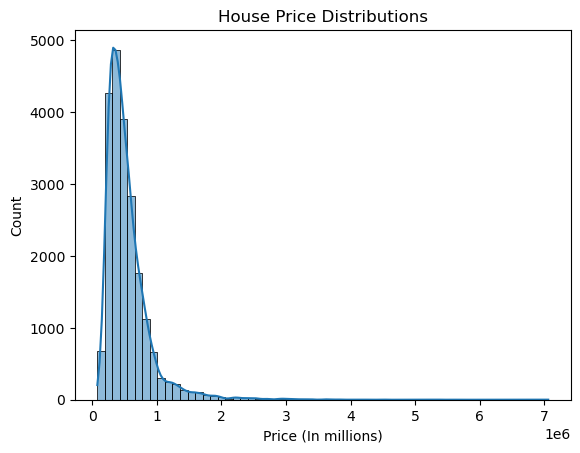

In [362]:
# Histogram of price
sns.histplot(house_updated_df['price'], kde = True, bins=60)
plt.title('House Price Distributions')
plt.xlabel('Price (In millions)')
plt.ylabel('Count')
plt.show()

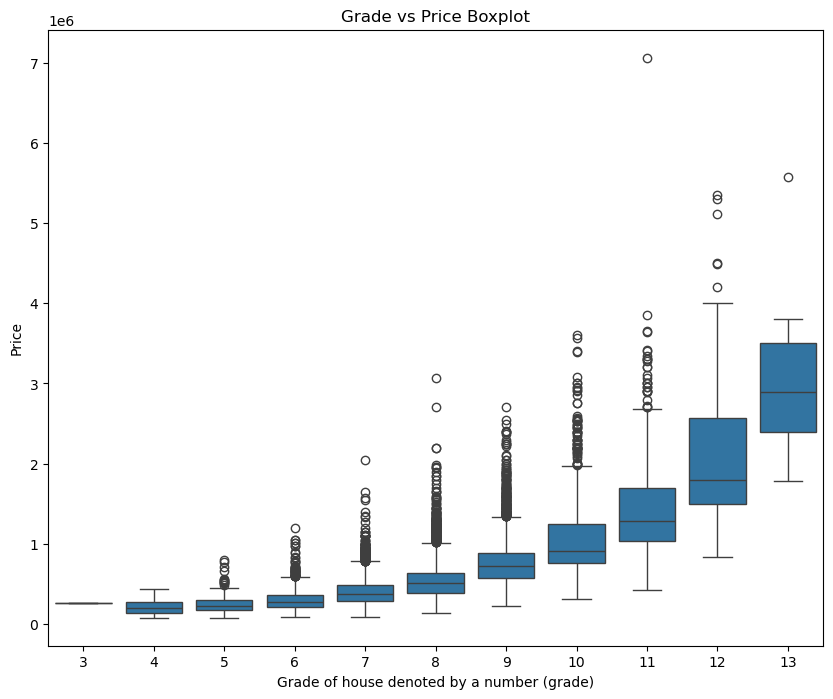

In [364]:
# Boxplot of grade and price
plt.figure(figsize = (10, 8))
sns.boxplot(x = 'grade', y = 'price', data = house_updated_df)
plt.title('Grade vs Price Boxplot')
plt.xlabel('Grade of house denoted by a number (grade)')
plt.ylabel('Price')
plt.show()

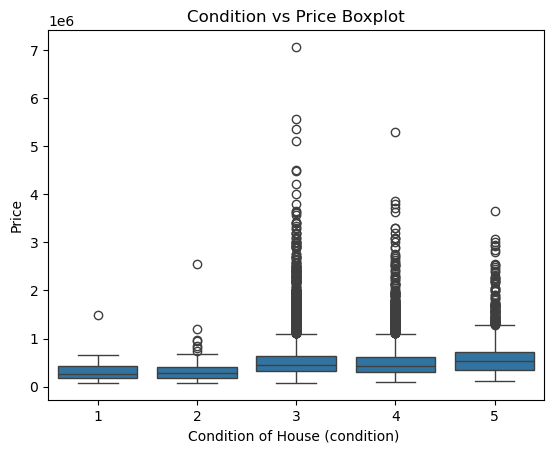

In [366]:
# Boxplot of condition and price
sns.boxplot(x = 'condition', y = 'price', data = house_updated_df)
plt.title('Condition vs Price Boxplot')
plt.xlabel('Condition of House (condition) ')
plt.ylabel('Price')
plt.show()

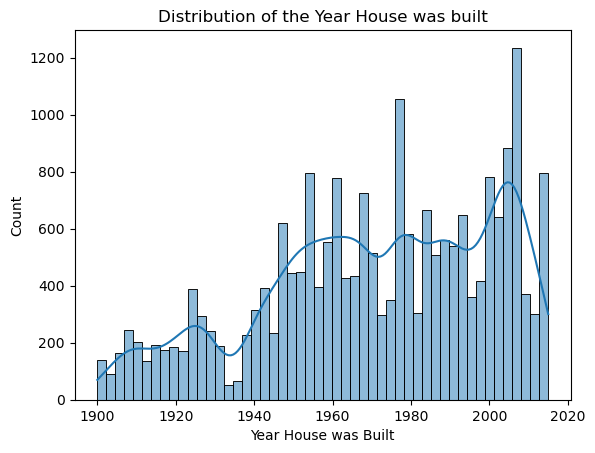

In [368]:
# Histogram of yr_built
sns.histplot(house_updated_df['yr_built'], kde = True, bins=50)
plt.title('Distribution of the Year House was built')
plt.xlabel('Year House was Built')
plt.ylabel('Count')
plt.show()

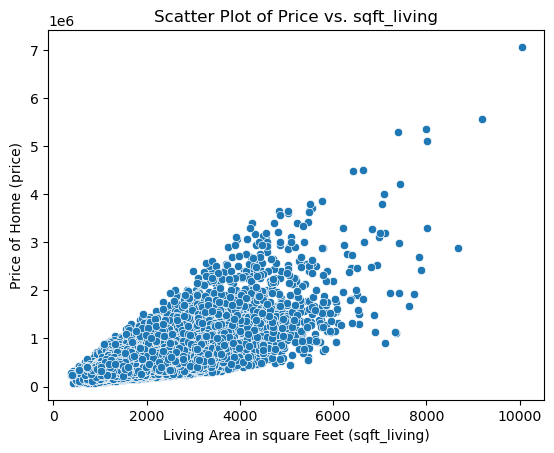

In [370]:
# Scatterplot of sqft_living and price
sns.scatterplot(x='sqft_living', y='price', data=house_updated_df)
plt.xlabel('Living Area in square Feet (sqft_living)')
plt.ylabel('Price of Home (price)')
plt.title('Scatter Plot of Price vs. sqft_living')
plt.show()

In [372]:
# Correlation Matrix
home_correlation_matrix = house_updated_df.drop(columns = ['id', 'date', 'zipcode', 'lat', 'long']).corr()
home_correlation_matrix

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
price,1.000000,0.320706,0.511490,0.697044,0.088539,0.257307,0.268956,0.396294,0.035472,0.671002,0.600022,0.314424,0.058218,0.122434
bedrooms,0.320706,1.000000,0.526506,0.600778,0.035487,0.188226,-0.001204,0.088213,0.020004,0.381337,0.498872,0.305154,0.179215,0.016858
bathrooms,0.511490,0.526506,1.000000,0.743196,0.086136,0.460188,0.065482,0.185737,-0.110169,0.646912,0.666639,0.285016,0.487615,0.049589
sqft_living,0.697044,0.600778,0.743196,1.000000,0.168986,0.353794,0.102162,0.280457,-0.060885,0.764434,0.874749,0.425043,0.325612,0.051519
sqft_lot,0.088539,0.035487,0.086136,0.168986,1.000000,-0.007117,0.022157,0.073493,-0.007421,0.110740,0.179665,0.012342,0.051546,0.008223
floors,0.257307,0.188226,0.460188,0.353794,-0.007117,1.000000,0.024494,0.027490,-0.265403,0.458334,0.524736,-0.251712,0.491827,0.005904
waterfront,0.268956,-0.001204,0.065482,0.102162,0.022157,0.024494,1.000000,0.402077,0.017046,0.081722,0.071656,0.076505,-0.026605,0.091016
view,0.396294,0.088213,0.185737,0.280457,0.073493,0.027490,0.402077,1.000000,0.046347,0.248677,0.162676,0.273600,-0.054219,0.102713
condition,0.035472,0.020004,-0.110169,-0.060885,-0.007421,-0.265403,0.017046,0.046347,1.000000,-0.148210,-0.161278,0.175897,-0.361490,-0.060407
grade,0.671002,0.381337,0.646912,0.764434,0.110740,0.458334,0.081722,0.248677,-0.148210,1.000000,0.756053,0.161723,0.450595,0.011606


In [374]:
# Correlation matrix - exclusing id and date
home_correlation_matrix2 = house_updated_df.drop(columns = ['id', 'date']).corr()
home_correlation_matrix2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
price,1.000000,0.320706,0.511490,0.697044,0.088539,0.257307,0.268956,0.396294,0.035472,0.671002,0.600022,0.314424,0.058218,0.122434,-0.053481,0.312930,0.023773
bedrooms,0.320706,1.000000,0.526506,0.600778,0.035487,0.188226,-0.001204,0.088213,0.020004,0.381337,0.498872,0.305154,0.179215,0.016858,-0.168289,-0.014922,0.149182
bathrooms,0.511490,0.526506,1.000000,0.743196,0.086136,0.460188,0.065482,0.185737,-0.110169,0.646912,0.666639,0.285016,0.487615,0.049589,-0.202978,0.023763,0.224759
sqft_living,0.697044,0.600778,0.743196,1.000000,0.168986,0.353794,0.102162,0.280457,-0.060885,0.764434,0.874749,0.425043,0.325612,0.051519,-0.202744,0.050749,0.245530
sqft_lot,0.088539,0.035487,0.086136,0.168986,1.000000,-0.007117,0.022157,0.073493,-0.007421,0.110740,0.179665,0.012342,0.051546,0.008223,-0.130113,-0.086817,0.228552
floors,0.257307,0.188226,0.460188,0.353794,-0.007117,1.000000,0.024494,0.027490,-0.265403,0.458334,0.524736,-0.251712,0.491827,0.005904,-0.059945,0.049046,0.126334
waterfront,0.268956,-0.001204,0.065482,0.102162,0.022157,0.024494,1.000000,0.402077,0.017046,0.081722,0.071656,0.076505,-0.026605,0.091016,0.030818,-0.014259,-0.042149
view,0.396294,0.088213,0.185737,0.280457,0.073493,0.027490,0.402077,1.000000,0.046347,0.248677,0.162676,0.273600,-0.054219,0.102713,0.085035,0.005307,-0.078178
condition,0.035472,0.020004,-0.110169,-0.060885,-0.007421,-0.265403,0.017046,0.046347,1.000000,-0.148210,-0.161278,0.175897,-0.361490,-0.060407,0.003010,-0.015475,-0.105970
grade,0.671002,0.381337,0.646912,0.764434,0.110740,0.458334,0.081722,0.248677,-0.148210,1.000000,0.756053,0.161723,0.450595,0.011606,-0.185966,0.113541,0.200843


Regression model using multiple variables, high R-squared at 0.6 poossible cause of multicolinearity concerns, like grade and condition, possibly that the higher the grade the better the condition, or sqft living and bathrooms, places with more living space are likely to have more bathrooms, or sqft_lot and waterfront, possible that waterfront lots have more land but not certain because depending on location, lots by the ocean dont have larger lots  
Price is our dependent variable and the other used in the linear regression would be our independent variables

In [264]:
x = house_updated_df[['sqft_living', 'sqft_lot', 'bathrooms', 'condition', 'grade', 'view', 'waterfront']]
y = house_updated_df['price']
x = sm.add_constant(x)
multi_regression = sm.OLS(y,x).fit()
print(multi_regression.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     4610.
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:26:49   Log-Likelihood:            -2.9605e+05
No. Observations:               21533   AIC:                         5.921e+05
Df Residuals:                   21525   BIC:                         5.922e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.816e+05    1.6e+04    -48.742      

The linear regression equation is as follows
Price = -7.816e+05 + (168.5197 * sqft_living) + (-0.2669 * sqft_lot) + (-2.641e+04 * bathrooms) + (1.079e+05 * grade) + (5.418e+04 * condition) + (6.527e+04 * view) + (5.926e+05 * waterfront)

In [345]:
x_bedbath = house_updated_df[['bedrooms', 'bathrooms']]
x_bedbath = sm.add_constant(x_bedbath)
y = house_updated_df['price']
bedbath_regression = sm.OLS(y,x_bedbath).fit()
print(bedbath_regression.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     3887.
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:41:00   Log-Likelihood:            -3.0259e+05
No. Observations:               21533   AIC:                         6.052e+05
Df Residuals:                   21530   BIC:                         6.052e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.789e+04   8630.856     -5.549      0.0

The linear equation is as follows:
Price = -47,890 + (29,400 * bedrooms) + (228,900 * bathrooms)
From this equation we can see that bathrooms affect the price of housing much more significantly than bedrooms do. The R-square of 0.265 shows that this model explains 26.5% of the variation in housing prices, since the R-square value is not really high, we can deduce that other variables that are not in this model play a significant role.

In [268]:
house_updated_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,2014-10-13,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257
1,6414100192,2014-12-09,538000.0,3,2.0,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319
2,5631500400,2015-02-25,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233
3,2487200875,2014-12-09,604000.0,4,3.0,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393
4,1954400510,2015-02-18,510000.0,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21528,263000018,2014-05-21,360000.0,3,2.5,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346
21529,6600060120,2015-02-23,400000.0,4,2.5,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362
21530,1523300141,2014-06-23,402101.0,2,1.0,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299
21531,291310100,2015-01-16,400000.0,3,2.5,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069


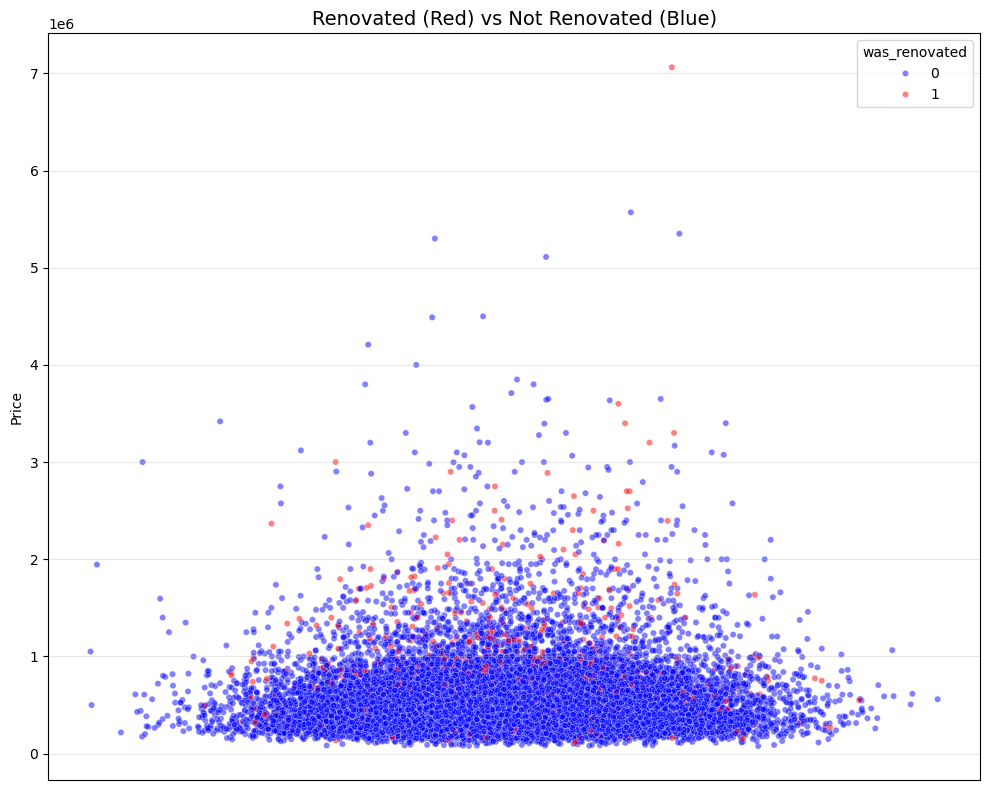

In [269]:
renovation_df = house_updated_df[['price', 'yr_renovated']].copy()
renovation_df['was_renovated'] = (renovation_df['yr_renovated'] != 0).astype(int)
renovation_df = renovation_df.drop('yr_renovated', axis=1)

plt.figure(figsize=(10, 8))
x = np.zeros(len(renovation_df))

jitter = np.random.normal(0, 0.02, size=len(renovation_df))
x_jittered = x + jitter

sns.scatterplot(
    x=x_jittered,
    y='price',
    hue='was_renovated',
    data=renovation_df,
    palette={0: 'blue', 1: 'red'},
    alpha=0.5,
    s=20
)

plt.title('Renovated (Red) vs Not Renovated (Blue)', fontsize=14)
plt.xlabel('') 
plt.ylabel('Price')
plt.xticks([])
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [270]:
renovation_counts = renovation_df['was_renovated'].value_counts()

print(f"(Not Renovated): {renovation_counts.get(0, 0)} homes")
print(f"(Renovated): {renovation_counts.get(1, 0)} homes")

(Not Renovated): 20626 homes
(Renovated): 907 homes


In [271]:
# We can see that renovagted homes constitutes only around 4% of the total amount of homes while not renovated 
# homes constitute around 96%. Although there is a larger percentage of not renovated homes, we can see that there 
# are a large amount of red dots (renovated homes) on the cluster graph. From this we can assume that renovated 
# homes have an increased price.

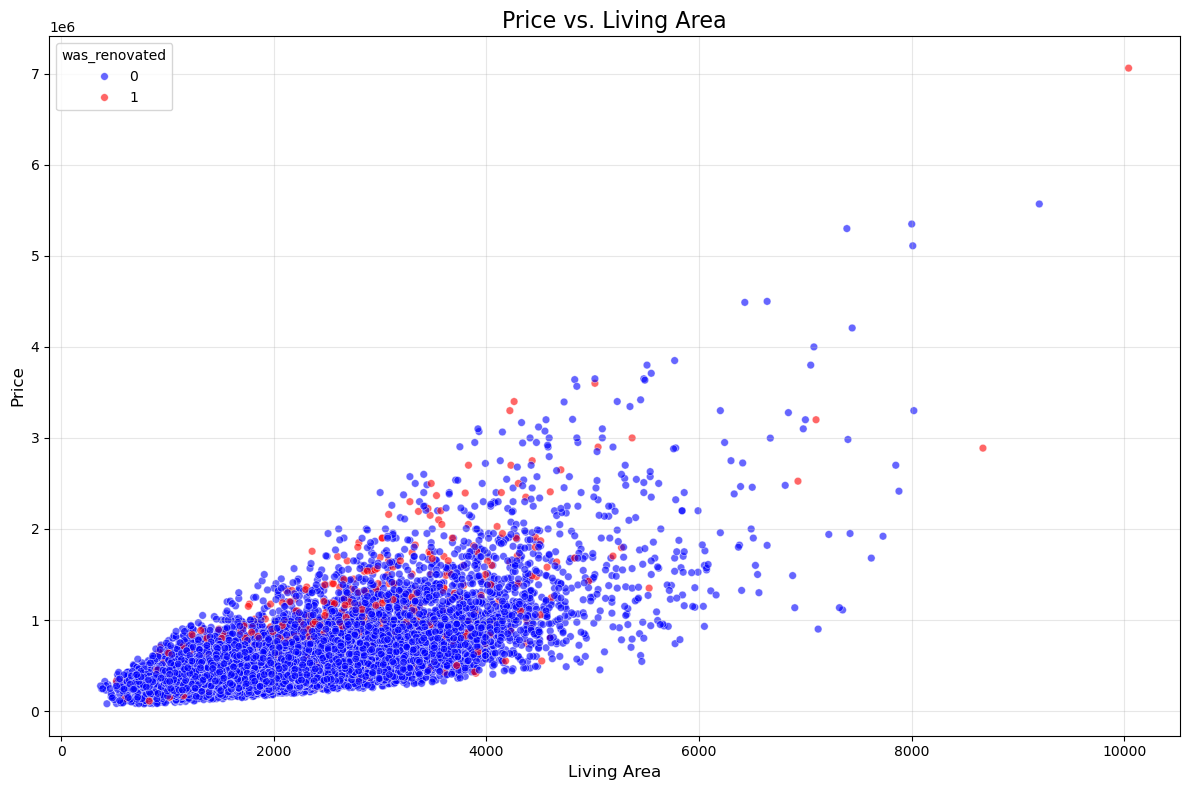

In [272]:
plot_df = house_updated_df[['price', 'sqft_living', 'yr_renovated']].copy()
plot_df['was_renovated'] = (plot_df['yr_renovated'] != 0).astype(int)

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='sqft_living',
    y='price',
    hue='was_renovated',
    data=plot_df,
    palette={0: 'blue', 1: 'red'},
    alpha=0.6,
    s=30
)

plt.title('Price vs. Living Area', fontsize=16)
plt.xlabel('Living Area', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Since living area was the variable with the highest correlation to price, I decided to create a cluster with sqft_living and price. Then I decided to color code the clusters based on whether the houses were remodeled or not. Once again, although there are thousands of more houses that were remodeled, we can see that the pricier the houses get, the more likely they are to have been remodeled.

For this project, since our end goal is to predict housing prices, it makes more sense to use a supervised learning model. This is because we already have labeled data with set outcomes that we can use to train our model. 

# Part 3: Data Analytics

In [348]:
# Supervised Learning Model
x_final = house_updated_df.drop(['price', 'lat', 'long', 'zipcode', 'yr_built', 'id', 'floors', 'date'], axis = 1)
y_final = house_updated_df['price']

# Convert yr_renovated to binary (as before)
x_final['was_renovated'] = (x_final['yr_renovated'] != 0).astype(int)
x_final = x_final.drop('yr_renovated', axis=1)

# Split data (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.2, random_state=0)

# Scale numerical features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.select_dtypes(include=['int64', 'float64']))
x_test_scaled = scaler.transform(x_test.select_dtypes(include=['int64', 'float64']))

In [350]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
y_pred = lr.predict(x_test_scaled)

# Calculate MSE first, then take square root for RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # This gives you RMSE

print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

RMSE: 218,774.64
R²: 0.598
